In [24]:
!pip install -r requirements.txt

  Using cached pandas-1.5.0-cp311-cp311-macosx_11_0_arm64.whl (10.7 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ortools 9.10.4067 requires pandas>=2.0.0, but you have pandas 1.5.0 which is incompatible.

[notice] A new release of pip available: 22.3 -> 24.1.2
[notice] To update, run: pip3 install --upgrade pip
Reshimming asdf python...


In [7]:
import crop_sim
import importlib
importlib.reload(crop_sim)

<module 'crop_sim' from '/Users/theron/code/crop-models/crop_sim.py'>

/Users/theron/.asdf/installs/python/3.11.0/lib/python3.11/site-packages/xarray/core/missing.py:264: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/Users/theron/.asdf/installs/python/3.11.0/lib/python3.11/site-packages/xarray/core/missing.py:264: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/Users/theron/.asdf/installs/python/3.11.0/lib/python3.11/site-packages/xarray/core/missing.py:264: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/Users/theron/.asdf/installs/python/3.11.0/lib/python3.11/site-packages/xarray/core/missing.py:264: FutureWarning: is_monotonic is deprecated and will be removed in a future version. Use is_monotonic_increasing instead.
  if not index.is_monotonic:
/Use

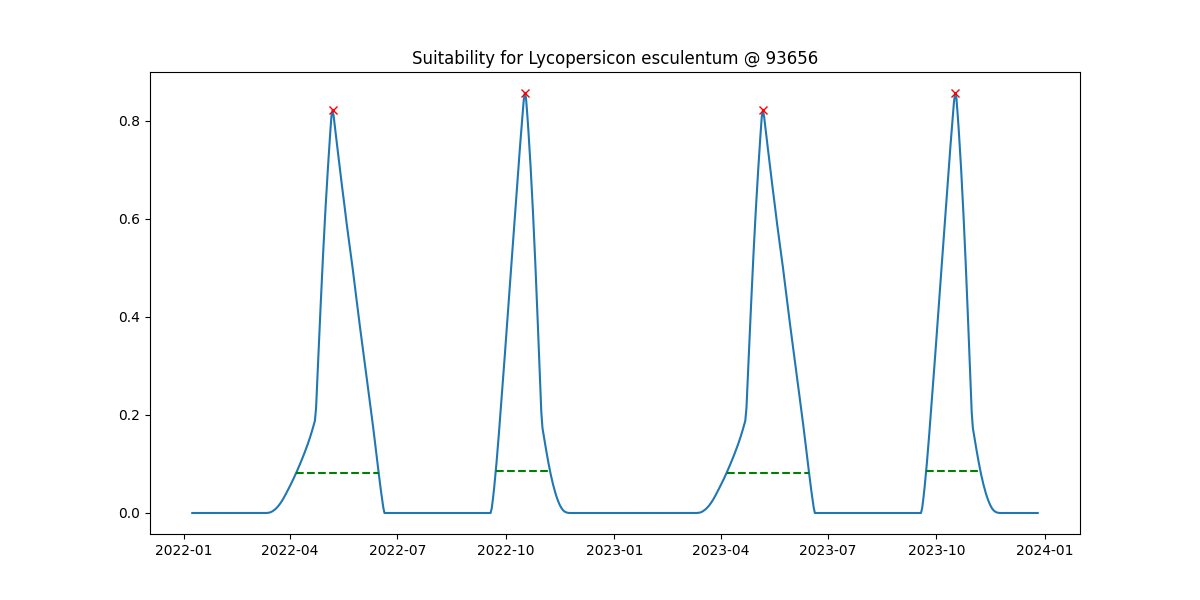

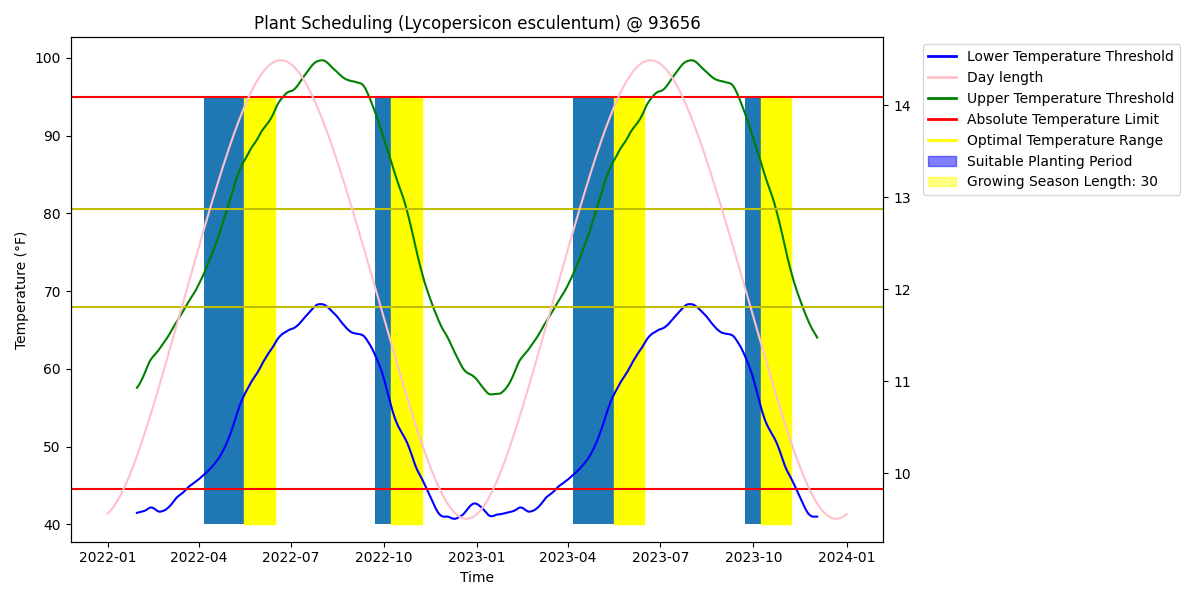

{30: [(4, 6, 5, 16), (9, 22, 10, 8)],
 40: [(4, 6, 5, 6), (9, 22, 9, 28)],
 50: [(4, 6, 4, 26)],
 60: [(4, 6, 4, 16)],
 70: [],
 80: [],
 90: [],
 100: [],
 110: [],
 120: [],
 130: [],
 140: [],
 150: []}

In [8]:
import matplotlib
matplotlib.pyplot.close()
%matplotlib widget

# Select your crop of interest (replace 'Maize' with your desired crop)
# crop_name = 'Allium cepa' #onion
crop_name= "Lycopersicon esculentum" # Tomatoes
# crop_name = "Brassica juncea" # Mustard greens
# crop_name = "Vigna unguiculata"
# crop_name = "Asparagus officinalis" # asparagus
# crop_name = "Ipomoea batatas" # sweet potato
# crop_name = "Solanum tuberosum" # Potato
# crop_name = "Cynara scolymus" # artichoke
bolting = False
frost_tolerance = 0

# 93922 monterey county

# short day: 11-12, long=14;16
min_day = 0
max_day = 24
# monterey = 93922
# SFO 94016
# Fresno 93656
# San Jose 95125
crop_sim.all_in_one("93656", crop_name, bolting, min_day, max_day)

In [631]:
# suit = growing_season_suitability[view_window]
# x = suit.where(suit > 0)
# y = xr.where(suit > 0, suit, 0)
# x == y
# print(suit)

In [646]:
# plt.subplots(figsize=(12, 6))

# # plt.plot(suit.time, .isel(lat=lat,lon=lon), color="green")
# plt.plot(suit.time, suit.isel(lat=lat,lon=lon))
# # from scipy.signal import savgol_filter
# # # Apply Savitzky-Golay filter
# # window_length = 13  # Must be odd
# # polyorder = 3

# # smoothed_data = xr.apply_ufunc(
# #     savgol_filter,
# #     suit,
# #     kwargs={"window_length": window_length, "polyorder": polyorder},
# #     input_core_dims=[["time"]],
# #     output_core_dims=[["time"]],  # Output is a single value per input
# #     output_dtypes=[suit.dtype]
# # )
# # plt.plot(smoothed_data.isel(lat=lat,lon=lon))
# plt.show()